In [264]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

## Importación de datos

Leemos el archivo y ordenamos por datetime

In [272]:
data_df = pd.read_csv('data_training/predictores_modelo_pasado.csv')
data_df['Datetime_hour'] = pd.to_datetime(data_df['Datetime_hour'])
data_df['day_of_week'] = data_df['Datetime_hour'].dt.dayofweek
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df

,Datetime_hour,Gen.PBF Hidraulica,Gen.PBF Nuclear,Gen.PBF Fotovoltaica,Gen.PVP Ciclo Combinado,Pot.Indisponible PBF,MD,IDA1,IDA2,Gen.PBF Eolica,Demanda PBF,Interconexiones PBF,Gen.PBF Total,Hour,Month,Day_of_week,Precio_Gas,Precio_CO2_lag24,day_of_week
0,2023-01-03 00:00:00,4959.6,7078.7,5.1,3091.6,5742.6,130.01,118.40,116.01,3357.4,21934.7,1181.1,21155.4,1.0,1.0,1.0,65.98,83.18,1
1,2023-01-03 01:00:00,4109.4,7078.7,5.1,2888.6,5742.6,120.00,115.00,114.90,3379.1,20466.0,1172.6,19802.2,2.0,1.0,1.0,65.98,83.18,1
2,2023-01-03 02:00:00,4086.7,7078.7,5.1,2889.3,5742.6,118.76,115.00,114.90,3377.8,19508.1,419.4,19650.6,3.0,1.0,1.0,65.98,83.18,1
3,2023-01-03 03:00:00,4079.2,7078.7,5.1,2869.8,5742.6,115.00,114.90,112.01,3384.1,19021.5,155.8,19427.6,4.0,1.0,1.0,65.98,83.18,1
4,2023-01-03 04:00:00,4078.0,7078.7,5.1,2876.1,5742.6,113.63,113.73,108.55,3407.4,19116.1,266.4,19461.6,5.0,1.0,1.0,65.98,83.18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23179,2025-08-25 19:00:00,4037.6,6811.5,7761.6,2708.4,10596.3,114.78,136.66,142.11,6790.4,28962.6,-3555.3,32823.4,21.0,8.0,0.0,33.59,71.97,0
23180,2025-08-25 20:00:00,5233.5,6810.5,2136.3,2727.3,10596.2,125.95,130.00,132.95,6985.0,28881.0,580.8,28576.8,22.0,8.0,0.0,33.59,71.97,0
23181,2025-08-25 21:00:00,5321.5,6812.5,81.1,3078.3,10596.1,142.00,139.40,142.98,7250.1,29056.5,2562.4,26640.2,23.0,8.0,0.0,33.59,71.97,0
23182,2025-08-25 22:00:00,4898.1,6817.0,0.2,3032.6,10596.0,123.11,123.01,123.21,7231.8,27707.7,2035.7,25977.4,0.0,8.0,1.0,33.00,71.48,0


In [273]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23184 entries, 0 to 23183
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Datetime_hour            23184 non-null  datetime64[ns]
 1   Gen.PBF Hidraulica       23184 non-null  float64       
 2   Gen.PBF Nuclear          23184 non-null  float64       
 3   Gen.PBF Fotovoltaica     23184 non-null  float64       
 4   Gen.PVP Ciclo Combinado  23184 non-null  float64       
 5   Pot.Indisponible PBF     23184 non-null  float64       
 6   MD                       23184 non-null  float64       
 7   IDA1                     23184 non-null  float64       
 8   IDA2                     23184 non-null  float64       
 9   Gen.PBF Eolica           23184 non-null  float64       
 10  Demanda PBF              23184 non-null  float64       
 11  Interconexiones PBF      23184 non-null  float64       
 12  Gen.PBF Total            23184 n

### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [274]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

## Parte 1 - Modelo con 24 outputs

### Preparacion datos

In [275]:
def create_sequences(df, input_steps, output_steps, target_column):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps - output_steps + 1, output_steps):
        X.append(data[i:i+input_steps, :])  # Ventana de entrada
        y.append(data[i+input_steps:i+input_steps+output_steps, target_idx])  # Ventana de salida

    return np.array(X), np.array(y)

In [285]:
### PARAMETROS
fecha_inicio = '2023-01-03'
fecha_fin = '2025-08-25'
cols_to_drop = ['IDA1', 'IDA2']

val_days = 30
test_days = 30
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

input_steps = 24*7
output_steps = 24

batch_size = 32

In [286]:
# Seleccionar valores
# data_df = data_df.loc[(data_df['Datetime_hour'] >= fecha_inicio) & (data_df['Datetime_hour'] <= fecha_fin)]
data_df_clean = data_df.drop(columns=cols_to_drop)


# Número de muestras
num_test_samples = test_days * 24
num_val_samples = val_days * 24
num_train_samples = len(data_df_clean) - num_val_samples - num_test_samples
# Division en train, val y test
data_df_input = data_df_clean.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences(train_df, input_steps, output_steps, 'MD')
X_val, y_val = create_sequences(val_df, input_steps, output_steps, 'MD')
X_test, y_test = create_sequences(test_df, input_steps, output_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (898, 168, 16), Val: (23, 168, 16), Test: (23, 168, 16)
Train: (898, 24), Val: (23, 24), Test: (23, 24)


C:\Users\jnavarro\AppData\Local\Temp\ipykernel_3708\903060139.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99878092 -0.99878092 -0.99878092 ... -0.4985614  -0.4985614
  0.00165811]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_3708\903060139.py:23: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.00165811  0.00165811  0.00165811  0.00165811  0.00165811  0.00165811
  0.00165811  0.00165811  0.00165811  0.00165811  0.00165811  0.00165811
  0.00165811  0.00165811  0.00165811  0.00165811  0.00165811  0.00165811
  0.00165811  0.00165811  0.00165811  0.00165811  0.00165811  0.50187762
  0.50187762  0.50187762  0.50187762  0.50187762  0.50187762  0.50187762
  0.50187762  0.50187762  0.50187762  0.50187762  0.50187762  0.50187762
  0.50187762  0.501

### Modelo LSTM

In [290]:
### PARAMETROS
dropout = 0.3
n_neurons = 128
r_drop = 0.1
patience = 10
lr = 0.0005
n_epochs = 50
regularizer = keras.regularizers.l2(1e-4)

In [291]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=False, kernel_regularizer=regularizer)(x)
x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(output_steps)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("lstm_multioutput.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.6871 - mae: 0.6613 - val_loss: 0.3909 - val_mae: 0.4649
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 0.3988 - mae: 0.4767 - val_loss: 0.3427 - val_mae: 0.4335
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 0.3458 - mae: 0.4382 - val_loss: 0.3136 - val_mae: 0.4120
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 0.3198 - mae: 0.4163 - val_loss: 0.2993 - val_mae: 0.4000
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 0.3128 - mae: 0.4111 - val_loss: 0.3057 - val_mae: 0.3968
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.3033 - mae: 0.4047 - val_loss: 0.3208 - val_mae: 0.4018
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 0.2871 - mae: 0.3908 - val_loss: 0.3246 - val_mae: 0.3995
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 0.2858 - mae: 0.3931 - val_loss: 0.3417 - val_mae: 0.4124
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - lo

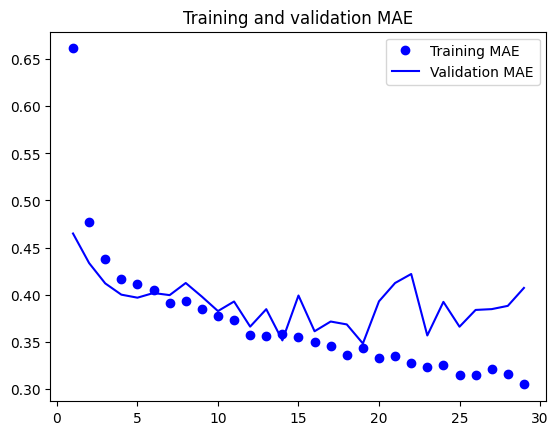

In [292]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Evaluación y resultados

In [293]:
model = keras.models.load_model("jena_lstm_dropout.keras")
y_pred = model.predict(X_test)

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)


rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
mae  = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
RMSE: 34.985
MAE : 27.592


In [294]:
test_dates = data_df['Datetime_hour'].iloc[-num_test_samples:].reset_index(drop=True)

# Como y_test tiene forma (n_muestras, 24), lo aplanamos
y_test_flat = y_test_rescaled.flatten()
y_pred_flat = y_pred_rescaled.flatten()

# Cortamos las fechas para que coincidan con el tamaño
test_dates = test_dates.iloc[:len(y_test_flat)]

# --- Crear dataframe para graficar ---
df_plot = pd.DataFrame({
    "Datetime": test_dates,
    "Real": y_test_flat,
    "Predicción": y_pred_flat
})

# Pasamos a formato long (para usar plotly express más fácil)
df_melted = df_plot.melt(id_vars="Datetime", value_vars=["Real", "Predicción"],
                         var_name="Serie", value_name="Precio")

# --- Gráfico interactivo ---
fig = px.line(df_melted, x="Datetime", y="Precio", color="Serie",
              title="Predicción vs Valores Reales (Periodo Test)")

# fig.update_traces(mode="lines+markers")
fig.update_layout(hovermode="x unified")

fig.show()

## Parte 2: 1 output step y forecast iterativo

### Preparación de datos

In [ ]:
input_steps = 24*2
output_steps = 1

In [133]:
def create_sequences_single_step(df, input_steps, target_column, step=1):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps, step):
        X.append(data[i:i+input_steps, :])             # Ventana de entrada
        y.append(data[i+input_steps, target_idx])      # Solo 1 paso hacia adelante

    return np.array(X), np.array(y).reshape(-1, 1)

In [134]:
X_train, y_train = create_sequences(train_df, input_steps, 1, 'MD')
X_val, y_val     = create_sequences(val_df,   input_steps, 1, 'MD')
X_test, y_test   = create_sequences(test_df,  input_steps, 1, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (21719, 48, 16), Val: (672, 48, 16), Test: (672, 48, 16)
Train: (21719, 1), Val: (672, 1), Test: (672, 1)


### Modelo LSTM

In [135]:
### PARAMETROS
dropout = 0.2
n_neurons = 64
r_drop = 0.25
patience = 6
lr = 0.0005
n_epochs = 50
regularizer = keras.regularizers.l2(1e-4)
batch_size = 64

In [136]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=False, kernel_regularizer=regularizer)(x)
x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.2654 - mae: 0.3779 - val_loss: 0.1568 - val_mae: 0.2807
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.1431 - mae: 0.2693 - val_loss: 0.1080 - val_mae: 0.2199
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.1149 - mae: 0.2399 - val_loss: 0.0930 - val_mae: 0.2080
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0993 - mae: 0.2210 - val_loss: 0.0868 - val_mae: 0.1997
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0897 - mae: 0.2093 - val_loss: 0.0701 - val_mae: 0.1772
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0810 - mae: 0.1975 - val_loss: 0.0694 - val_mae: 0.1723
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0742 - mae: 0.1891 - val_loss: 0.0626 - val_mae: 0.1624
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.0703 - mae: 0.1830 - val_loss: 0.0568 - val_mae: 0.1552
Epoch 9/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 

In [139]:
def iterative_forecast(model, X_init, steps, y_scaler=None, target_idx=None):
    """
    X_init: ventana inicial (shape = (1, input_steps, features))
    steps : número de pasos a predecir (ej. 24)
    target_idx: posición de la columna 'MD' en tus features
    """
    preds = []
    current_input = X_init.copy()

    for _ in range(steps):
        # Predecir una hora
        next_pred = model.predict(current_input, verbose=0)
        preds.append(next_pred[0, 0])

        # Construir la nueva fila con las features anteriores
        new_row = current_input[0, -1, :].copy()
        
        # Sustituir en la columna de 'MD' por la predicción
        if target_idx is not None:
            new_row[target_idx] = next_pred
        else:
            # fallback: última columna
            new_row[-1] = next_pred

        # Shift de la ventana
        current_input = np.append(current_input[0, 1:, :], new_row.reshape(1, -1), axis=0)
        current_input = current_input.reshape(1, current_input.shape[0], current_input.shape[1])

    preds = np.array(preds).reshape(-1, 1)
    return y_scaler.inverse_transform(preds) if y_scaler else preds


In [ ]:
def iterative_forecast(
    model,
    X_seed,                 # shape (1, input_steps, n_features)
    steps,                  # p.ej. 24
    target_idx,             # posición de 'MD' en las columnas
    exog_future=None,       # array (steps, n_exog) con las features futuras ya ESCALADAS
    exog_idx=None           # posiciones de esas columnas exógenas dentro del vector de features
):
    """
    Devuelve predicciones en ESCALA DEL MODELO (las podrás invertir con y_scaler fuera).
    """

    preds = np.empty((steps, 1), dtype=float)
    current = X_seed.copy()

    for k in range(steps):
        yhat = model.predict(current, verbose=0)     # (1,1)
        preds[k, 0] = yhat[0, 0]

        # Base para la siguiente fila: parte de la última, pero la vamos a reemplazar
        new_row = current[0, -1, :].copy()

        # 1) Actualiza exógenas con sus valores del tiempo futuro k
        if exog_future is not None and exog_idx is not None:
            new_row[exog_idx] = exog_future[k]

        # 2) Inserta la predicción (en ESCALA del modelo) en la columna MD
        new_row[target_idx] = yhat[0, 0]

        # 3) Desliza la ventana
        current = np.concatenate([current[0, 1:, :], new_row.reshape(1, -1)], axis=0)
        current = current.reshape(1, current.shape[0], current.shape[1])

    return preds  # aún en escala estandarizada

In [151]:
target_idx = test_df.columns.get_loc("MD")
exog_cols  = [c for c in test_df.columns if c != "MD"]
exog_idx   = [test_df.columns.get_loc(c) for c in exog_cols]

# Para el PRIMER bloque: exógenas de las 24 horas siguientes (ya escaladas)
exog_future = test_df[exog_cols].iloc[input_steps : input_steps + 24].to_numpy()

# Semilla (primera ventana)
X_seed = X_test[0:1]

# Predicción en escala estandarizada
preds_scaled = iterative_forecast(
    model, X_seed, steps=24,
    target_idx=target_idx,
    exog_future=exog_future,
    exog_idx=exog_idx
)

# Invertir escala para comparar
forecast_24h = y_scaler.inverse_transform(preds_scaled)        # (24,1)
real_24h     = y_scaler.inverse_transform(y_test[0:24]) 

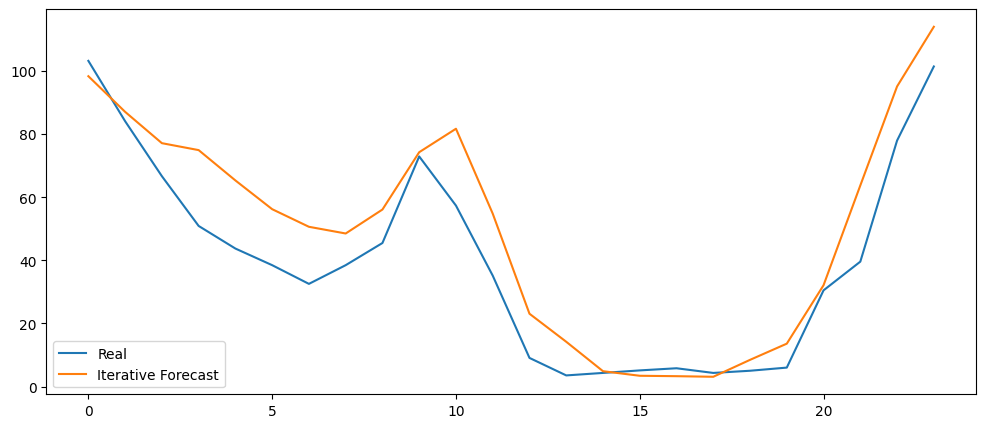

In [152]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(real_24h, label="Real")
plt.plot(forecast_24h, label="Iterative Forecast")
plt.legend(); plt.show()

## Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [125]:
md_true = []
md_delay_day = []
data_array = data_df_input.values

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_day = np.array(md_delay_day)

print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE day-delay: 19.21110949380838


Evolución del entrenamiento

In [99]:
y_pred_rescaled.shape

(923, 24)